<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/diffusers/sd_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stable Latent Diffusion : Generation & Interpolation

**Stable Latent Diffusion** combines a Diffusion UNet and a Variational Autoencoder (VAE) to generate images by denoising random noise in a compressed latent space.

- **VAE Encoder**: Compresses the image into latent space.
- **UNet**: Operates in this latent space, performing the denoising process.
- **VAE Decoder**: Converts the denoised latent representation back into the full-resolution image.

In this notebook, we'll explore how to manipulate the latent space :
- [x] Random Walks on Prompt-Text: Adding noise to the prompt embeddings to create variations.
- [ ] Random Walks on Latent Space: Exploring variations directly in the latent representation of the image.
- [ ] Prompt-Based Interpolations: Interpolating between embeddings of different prompts to generate smooth transitions (Slerp and Lerp)

## Constants

In [15]:
# Parameters for image generation.
WIDTH, HEIGHT = 512, 512
NUM_INFERENCE_STEPS=15
GUIDANCE_SCALE=8

## Load Stable Diffusion Pipeline

Load the Stable Diffusion pipeline, which includes tools like the text encoder (to process prompts), UNet (to denoise), and VAE (to handle images). We also set up a scheduler to control the denoising process.

In [17]:
from PIL import Image
from IPython.display import display

import torch
from diffusers import StableDiffusionPipeline
from diffusers import LMSDiscreteScheduler

# Clear GPU memory
torch.cuda.empty_cache()

# Set up the scheduler for the denoising process
scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    steps_offset=1.0,
)

# Use GPU if available, otherwise fall back to CPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Load the Stable Diffusion pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    scheduler=scheduler,
    torch_dtype=torch.float16,
).to(device)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## Prepare Text Conditioning


Instead of letting the pipeline handle the text prompt directly, we'll create a text embedding manually. This involves two steps:

1. **Tokenizer**: Breaks the prompt into tokens the model can understand.
2. **Text Embedding**: Converts the tokens into a numerical representation for the model.

In [18]:
def get_text_embedding(prompt, pipeline, device):
    # Tokenize the prompt
    prompt_tokens = pipeline.tokenizer(
        prompt,
        padding="max_length",
        max_length=pipeline.tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    # Create and return the embedding
    return pipeline.text_encoder(prompt_tokens.input_ids.to(device))[0]


prompt = "Beautiful sunset over snowy mountains, warm light, serene and peaceful"
prompt_embedding = get_text_embedding(prompt, pipe, device)
print(f"The text embedding shape is: {prompt_embedding.shape}")

The text embedding shape is: torch.Size([1, 77, 768])


## Calculate latent size of VAE bottleneck (optional)

The VAE bottleneck is where the image is compressed into its latent representation. To calculate the latent size, we need to determine how many downsampler layers the VAE encoder has, as each downsampler reduces the spatial dimensions by a factor of 2.

**Method 1: Counting Downsampler Layers**

We manually count the downsampler layers in the VAE encoder to calculate the latent size:

In [19]:
# Function to count the number of downsampler layers
def get_num_downsampler_layers(vae) -> int:
    downsampler_count = 0
    for block in vae.encoder.down_blocks:
        if hasattr(block, "downsamplers") and block.downsamplers:
            downsampler_count += 1
    return downsampler_count

# Get the number of downsampler layers and latent size
num_downsampler = get_num_downsampler_layers(pipe.vae)
latent_size = 2 ** num_downsampler

print(f"Number of downsampler layers: {num_downsampler}")
print(f"Latent size factor: {latent_size}")

Number of downsampler layers: 3
Latent size factor: 8


**Method 2: Deriving Latent Size by Direct Image Input**

Alternatively, we can pass a sample image tensor through the VAE encoder and measure the output size to determine the latent dimensions:


In [21]:
# Create a dummy image tensor (batch_size, channels, height, width)
dummy_image = torch.zeros(1, 3, HEIGHT, WIDTH, device=device, dtype=torch.float16)

# Pass it through the VAE encoder and get the shape of the latent representation
with torch.no_grad():
    latent = pipe.vae.encode(dummy_image).latent_dist.sample()

latent_height, latent_width = latent.shape[-2], latent.shape[-1]
latent_factor = HEIGHT // latent_height  # Assuming the same downscale factor for width and height

print(f"Latent shape: {latent.shape}")
print(f"Latent height: {latent_height}, Latent width: {latent_width}")
print(f"Latent size factor: {latent_factor}")


Latent shape: torch.Size([1, 4, 64, 64])
Latent height: 64, Latent width: 64
Latent size factor: 8


## Generate a single image




Generate an image from the text embedding. We'll recompute the embedding and add random noise (`wiggle_scale`) to explore variations around the prompt.

  0%|          | 0/15 [00:00<?, ?it/s]

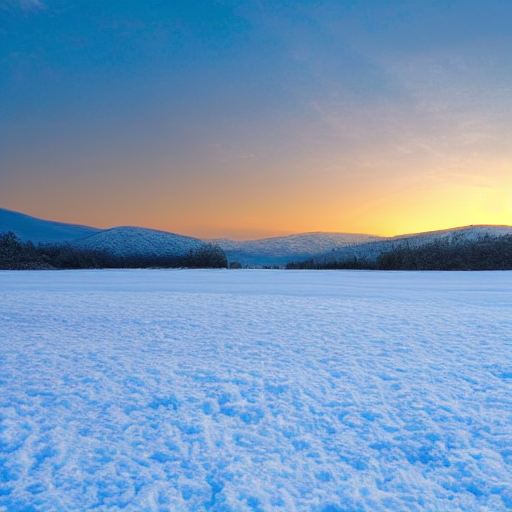

In [22]:
def generate_image(pipeline, prompt_embeds, wiggle_scale=0.0):
    # Add noise for variation
    noise = prompt_embeds + torch.randn_like(prompt_embeds) * wiggle_scale
    # Set random seed for reproducibility
    generator = torch.manual_seed(10)

    # Generate the image
    images = pipeline(
        height=HEIGHT,
        width=WIDTH,
        num_images_per_prompt=1,
        prompt_embeds=noise,
        num_inference_steps=NUM_INFERENCE_STEPS,
        guidance_scale=GUIDANCE_SCALE,
        generator=generator,
    ).images

    return images[0]

prompt = "Beautiful sunset over snowy mountains, warm light, serene and peaceful"
prompt_embedding = get_text_embedding(prompt, pipe, device)
image = generate_image(pipe, prompt_embedding, wiggle_scale=0.1)
display(image)


## Random Walk on Prompt Latent

We'll create an animation by performing a **random walk** on the prompt embedding and generating images for each step.

In [25]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


# Parameters
num_frames = 5 # Number of steps in the random walk
wiggle_scale = 0.02  # Scale of noise added at each step

# Generate images for the animation
images = []
prompt = "Dreamy forest with magical glowing trees, misty atmosphere, and soft lighting"
prompt_embeds = get_text_embedding(prompt, pipe, device)
curr_embedding = prompt_embeds.clone()
for i in range(num_frames):
    # Add small random noise to the embedding
    curr_embedding = curr_embedding + torch.randn_like(curr_embedding) * wiggle_scale

    # Generate an image for the current embedding
    img = generate_image(pipe, curr_embedding, wiggle_scale=0.0)
    images.append(img)

# Set up the figure for the animation
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(np.asarray(images[0]))
ax.axis("off")  # Hide axes

# Function to update the figure
def update_figure(frame):
    im.set_array(np.asarray(images[frame]))
    return [im]

plt.close(fig)  # Close the figure to prevent static display

# Create the animation
anim = FuncAnimation(fig, update_figure, frames=num_frames, interval=200)  # interval in ms

# Display the animation in the notebook
HTML(anim.to_jshtml())


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

## Resources

Explore these useful guides to deepen your understanding of Stable Diffusion:

- [Hugging Face Cookbook: Stable Diffusion Interpolation](https://huggingface.co/learn/cookbook/en/stable_diffusion_interpolation)  
  Learn how to interpolate between different text prompts and generate smooth transitions.

- [Keras Example: Random Walks with Stable Diffusion](https://keras.io/examples/generative/random_walks_with_stable_diffusion_3/)  
  A practical example of performing random walks in the latent space of Stable Diffusion.